# Measuring the probability distributions of Rydberg Hamiltonians
We know what the different topological phases are for different variations of the Hamiltonian at the ground state.
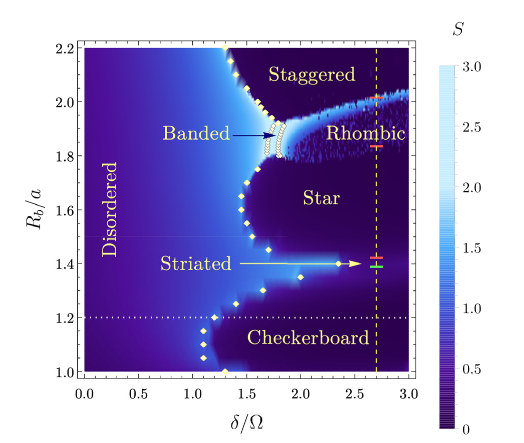

https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.124.103601

My goal is to explore this at different temperatures. In particular, we want to find a way to differentiate between temperatures.

When we make a measurement from the quantum computer or qmc on the rydberg atom array, we will obtain a sequence of 0s and 1s, with one digit corresopnding to each atom. If we represent a single sequence of 1s and 0s as the vector $\mathbf{x}$, then we would like to know what the probability distribution of the data is $p(\mathbf{x})$.

In the case of a 16x16 atom array, there are $2^{256}$ different possible states, though not all of them are reasonably likely. If we assume that there are $N$ equally probable states, if we were to sample $k$ times then the probability of none of them having the state is:

$$P(\text{unique states})=\frac{N!}{(N-k)!k^N}\approx\frac{(N/e)^N}{((N-k)/e)^{N-k} k^N}=\left(\frac{1}{(1-k/N)k}\right)^N=\frac{1}{k^Ne^{N \ln(1-k/N)}}\approx\frac{e^{k}}{k^N}$$
For a 16x16 array, we take $N=2^{256}$ and $k=10^6$
$$P(\text{unique states})=(1-2^{-256})^{0.5\cdot 10^6\cdot 10^6}\approx  1-10^{-65}$$
Note that $N$ is most definitely not this large and not all the probabilities are the same, but this is a heuristic.
For a 4x4 array, we take $N=2^{16}\approx 6\times 10^4$ and $k=10^6$, and we note that there are more samples than unique states so we cannot physically have all states be unique.


## The scaling problem
If we can reasonably measure a quantum computer $N=10^6$ times, we can only learn so much about the system.

If we have $n=20$ atoms, where each configuration of them has equal probabilities. Or, put in another way, if we have $2^n=2^{20}\approx 1.4\times 10^6$ states of the system which all have equal probability, then after $N$ measurements, half of them will be measured.
$$p=(1-2^{-n})^N\Rightarrow n=-\frac{\ln (1-p^{1/N})}{\ln 2}\approx 20.46 \quad (p=1/2)$$
Note that if we wanted $n=16\times 16$ atoms, this would have considerably more that $2^{20}$ possible states (though we can't say how many there are), making it very unlikely for any configuration to be measured twice. 

Thus trivially comparing sample distributions (simulation vs qc will not work), since the distributions will have nothing in common. 

Then how to we find the temperature? 
- We compute the average occupation.

How do we test if the noise of a quantum computer obeys the Gibbs distribution?
- Sample enough to get good number statistics on probability distribution. If the JSD divergence between distributions makes a noticable trough, then we would expect that to be the temperature. If the JSD is within the range of what it should be for a Gibbs state then it obeys the Gibbs distribution.
- If we can't sample enough to get good number statistics, the above approach cannot be used. In such a case
    * Use a neural network to find a probability distribution for the simulation, hopefully the data sampled informs the model enough of the population that it can accurately make predictions on new data (which will most likely be from outside the existing dataset). With this distribution, 

# Critical point of 16x16 array

In [119]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
import numpy as np
import matplotlib.pyplot as plt
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(16,16), Rb_per_a=1.2, delta_per_omega=1.1)
def get_deepest_pair(x):
    def search(check, depth=0):
        if np.sum(check) <= 1:
            return depth
        y1 = search(check*(x[:,depth]==0), depth+1)
        y2 = search(check*(x[:,depth]==1), depth+1)
        return max(y1,y2)
    return search(np.ones(len(x)))
get_deepest_pair(dataset.get_dataset(0)[0][:].T)

/project/6000317/jkambulo/code/qc-temp/transformer


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Probability distribribution for $\Delta=0.5$ and $R_b=1.2$

/project/6000317/jkambulo/code/qc-temp/transformer
0.19310344827586207


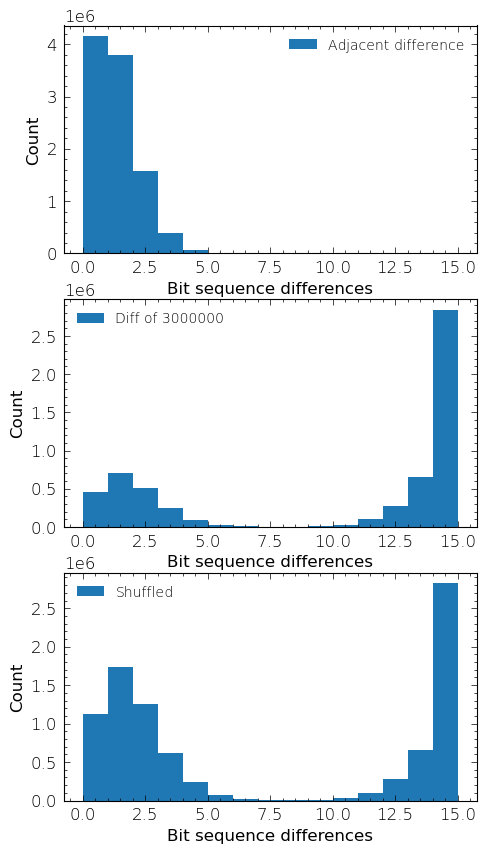

In [ ]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
import numpy as np
import matplotlib.pyplot as plt
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=2.7)
data = dataset.get_dataset(3)
print(dataset.get_beta(3))

## for delta=0.5, it is mostly uncorrelated at 20-30 (not really at 10)
## for delta=1.1, it is mostly uncorrelated at 200-300

index = np.arange(data.shape[1])
np.random.shuffle(index)
data = data[:].T
fig, ax = plt.subplots(3,1, figsize=(5,10))

ax[0].hist(np.sum(np.abs(data[1:] - data[:-1]), axis=1), bins=list(range(16)), label='Adjacent difference')
ax[0].set_xlabel("Bit sequence differences")
ax[0].set_ylabel("Count")
ax[0].legend()

n = 3_000_000
ax[1].hist(np.sum(np.abs(data[n:] - data[:-n]), axis=1), bins=list(range(16)), label=f'Diff of {n}')
ax[1].set_xlabel("Bit sequence differences")
ax[1].set_ylabel("Count")
ax[1].legend()
data = data[index]
ax[2].hist(np.sum(np.abs(data[1:] - data[:-1]), axis=1), bins=list(range(16)), label='Shuffled')
ax[2].set_xlabel("Bit sequence differences")
ax[2].set_ylabel("Count")
ax[2].legend()
plt.show()
# print(np.mean(np.sum(np.abs(data[300:] - data[:-300]),axis=1)))
# data = data[index]
# print(np.mean(np.sum(np.abs(data[1:] - data[:-1]),axis=1)))

For $\beta=0.1$
* For $\Delta=0.5$, it is mostly uncorrelated after 20-30 iterations
* For $\Delta=1.1$, it is mostly uncorrelated after 200-300 iterations
* For $\Delta=2.7$, it is mostly uncorrelated after ~50,000 iterations

For $\beta=0.16$
* For $\Delta=2.7$, it is mostly uncorrelated after ~500,000-1,000,000+ iterations

For $\beta=0.19$
* For $\Delta=2.7$, it is mostly uncorrelated after ~3,000,000+ iterations (can't fully test with this approach)

For $\beta=1.0$
* For $\Delta=0.5$, it is mostly uncorrelated after 20-30 iterations
* For $\Delta=1.1$, it is mostly uncorrelated after ~800 iterations
* Fpr $\Delta=2.7$, it is mostly uncorrelated after 30-40 iterations

For the checkerboard pattern, the autocorrelation time is too large (larger than $10^7$) so the state becomes non-ergotic for even reasonably somewhat high temperatures. 

In [149]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
import numpy as np
import matplotlib.pyplot as plt
from dataloader import QCTempDataset
from scipy.spatial.distance import jensenshannon
plt.style.use('../../style.mplstyle')

def compute_histograms(dataset: QCTempDataset, dataset_slice=slice(None), filter_data=slice(None), atoms=None):
    natoms = atoms if atoms else dataset.get_natoms()
    f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
    data_list = dataset.datasets[dataset_slice]
    beta_list = dataset.beta[dataset_slice]
    order_param_list = dataset.order_param[dataset_slice]
    ncomb = 2**natoms

    bins = np.arange(ncomb)
    hist_list = [np.histogram(f(data[:][filter_data].T), bins=bins)[0] for data in data_list]        
    index_commonality = [np.argsort(hist) for hist in hist_list]
    order_params, op_counts = zip(*[np.unique(order_param, return_counts=True) for order_param in order_param_list])
    magnetization = [np.sum(data[filter_data],axis=0) for data in data_list]
    average_magnetization = [np.mean(mag) for mag in magnetization]
    std_av_magnetization = [np.std(mag)/np.sqrt(len(mag)-1) for mag in magnetization]
    return (bins, hist_list), (order_params[0], op_counts), (average_magnetization, std_av_magnetization), index_commonality, beta_list 


def plot_JSD(p_list, beta_list, delta, beta_of_interest=None, show=True):
    if beta_of_interest:
        qm_p_list = p_list[beta_of_interest]
    else:
        qm_p_list = p_list
        
    for i, p1 in enumerate(qm_p_list):
        y = []
        for j, p2 in enumerate(p_list): 
            y.append(jensenshannon(p1, p2))
        #     print(f"KLdiv beteen β={beta_list[i]:.3} and β={beta_list[j]:.3}: {np.sum(hist1[_filter]*np.log(hist1[_filter]/hist2[_filter]))/nsamples}")
        # print()
        
        plt.scatter(beta_list, y, label=f"β={beta_list[i]}")
    # plt.legend()
    plt.grid()
    plt.title(f'Δ={delta}, Rb=1.2, 4x4 array')
    plt.xlabel('β')
    plt.ylabel(r'$JSD(p(\beta_1)||p(\beta_2))$')
    if show:
        plt.show()
    
def plot_KLdiv(p_list, beta_list, delta, beta_of_interest=None, show=True):
    if beta_of_interest:
        qm_p_list = p_list[beta_of_interest]
    else:
        qm_p_list = p_list
        
    for i, p1 in enumerate(qm_p_list):
        y = []
        for j, p2 in enumerate(p_list): 
            # hist2 = np.random.poisson(hist2, len(hist2))
            _filter = (p1 > 0) & (p2 > 0)
            y.append(np.sum(p1[_filter]*np.log(p1[_filter]/p2[_filter])))
        #     print(f"KLdiv beteen β={beta_list[i]:.3} and β={beta_list[j]:.3}: {np.sum(hist1[_filter]*np.log(hist1[_filter]/hist2[_filter]))/nsamples}")
        # print()
        
        plt.scatter(beta_list, y, label=f"β={beta_list[i]}")
    # plt.legend()
    plt.grid()
    plt.title(f'Δ={delta}, Rb=1.2, 4x4 array')
    plt.xlabel('β')
    plt.ylabel('KLdiv(p(β1)||p(β2))')
    if show:
        plt.show()
    

def plot_common_configurations(p, beta, index_commonality, natoms, delta, show=True):
    bins = np.arange(2**natoms)
    freq = p[index_commonality[-1]]
    print(f"{freq*100} +- {np.sqrt(freq/1e6)*100}")

    nx, ny = 5,5
    _, axs = plt.subplots(ny, nx, figsize=(5.5, 7))
    nx_atoms = int(round(np.sqrt(natoms)))
    for j in range(nx*ny):
        i = index_commonality[-(j+1)]
        ax = axs.flatten()[j]
        ax.axis('off')
        ax.imshow(np.array(list(np.binary_repr(bins[i],width=natoms)),dtype=int).reshape((nx_atoms,nx_atoms)),cmap='magma')
        ax.set_title(f"{p[i]*100:.4f}%")
    plt.subplots_adjust(left=0,
                        bottom=0,
                        right=1,
                        top=0.9,
                        wspace=0,
                        hspace=0.4)
    plt.suptitle(rf"Δ={delta}, Rb=1.2, β={beta:.3}")
    if show:
        plt.show()
    

def plot_sorted_hist(hist_list, beta_list, sorted_indices, delta, show=True):
    for hist, beta, index_commonality in zip(hist_list, beta_list, sorted_indices):
        # total_number = 1e7
        # freq = hist[index_commonality[-1]]
        # print(f"{freq/total_number*100} +- {np.sqrt(freq)/total_number*100}")
        plt.plot(hist[index_commonality[::-1]], label=rf"β={beta:.3}")
    plt.yscale('log')
    plt.xscale('log')
    plt.ylabel('Frequency')
    plt.xlabel('Configurations (sorted by frequency)')
    plt.title(f'Δ={delta}, Rb=1.2, 4x4 array')
    plt.legend()
    plt.grid()
    if show:
        plt.show()
    

/project/6000317/jkambulo/code/qc-temp/transformer


/project/6000317/jkambulo/code/qc-temp/transformer
[ 1.57402836e-01 -2.28580470e+02  3.17369560e-01  2.04453628e+00]


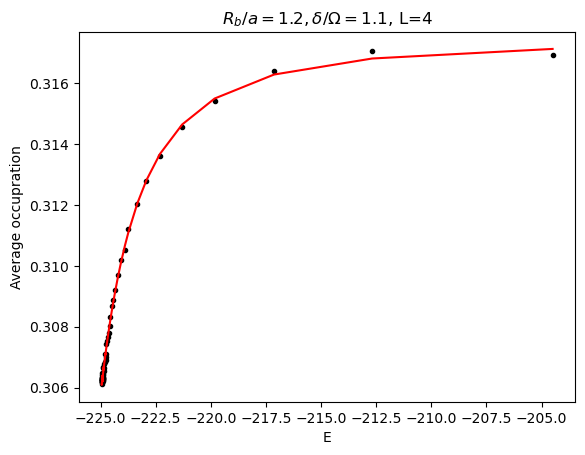

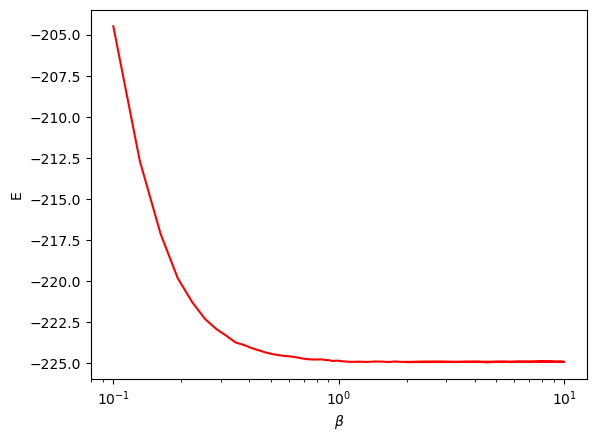

In [8]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
import matplotlib.pyplot as plt
from dataloader import QCTempDataset
import numpy as np
from scipy.optimize import curve_fit
L = 4
Rb = 1.2
delta = 1.1
# dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(L,L), Rb_per_a=Rb, delta_per_omega=delta)
# plt.errorbar(dataset.beta, dataset.energy, yerr=dataset.energy_error, fmt='.')
# y = [np.mean(data) for data in dataset.datasets]
f = lambda x, a, b,c,p: -a/(x-b)**p+c
# popt, pcov = curve_fit(f, dataset.energy, y, p0=[1,np.min(dataset.energy)*1.1, np.max(y),3], maxfev=5000)
print(popt)
plt.scatter(dataset.energy, y, marker='.', c='k')
plt.plot(dataset.energy, f(np.array(dataset.energy), *popt),c='r')
plt.title(rf"$R_b/a={Rb}, \delta/\Omega={delta}$, L={L}")
plt.ylabel('Average occupration')
plt.xlabel(r'E')
plt.show()

plt.plot(dataset.beta, dataset.energy ,c='r')
plt.ylabel('E')
plt.xlabel(r'$\beta$')
plt.xscale('log')
plt.show()

In [ ]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
delta = 0.5
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=delta)

nsamples = dataset.get_nsamples()
natoms = dataset.get_natoms()
(bins, hist_list), (order_params, op_counts), (average_magnetization, std_av_magnetization), sorted_indices, beta_list = compute_histograms(dataset)

/project/6000317/jkambulo/code/qc-temp/transformer


findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman
findfont: 

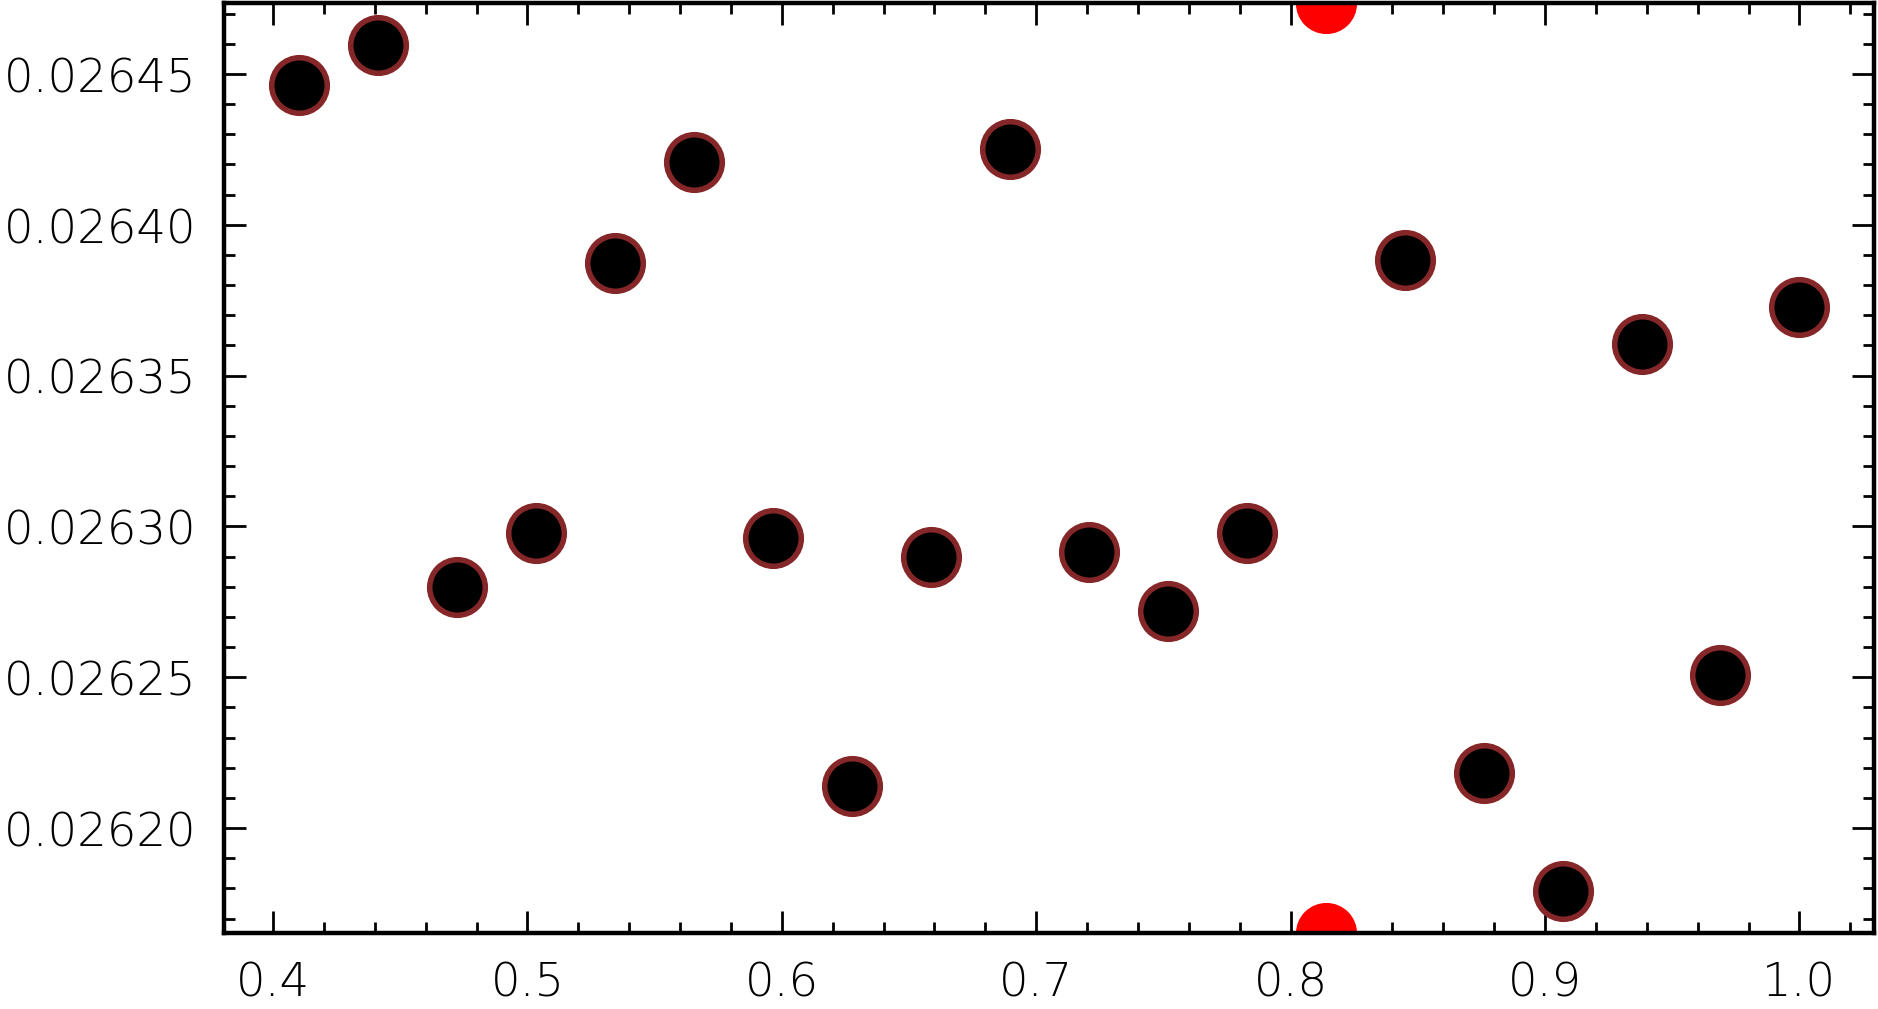

In [ ]:
!rm ~/.cache/matplotlib -rf
from scipy.spatial.distance import jensenshannon
import matplotlib.pyplot as plt
import numpy as np

j = 23
x = [i for i in range(10,30) if i!=j]
plt.plot([dataset.get_beta(i) for i in x],[jensenshannon(hist_list[i], hist_list[j]) for i in x],c='k')
plt.axvline(x=dataset.get_beta(j),c='r')
plt.show()

/project/6000317/jkambulo/code/qc-temp/transformer


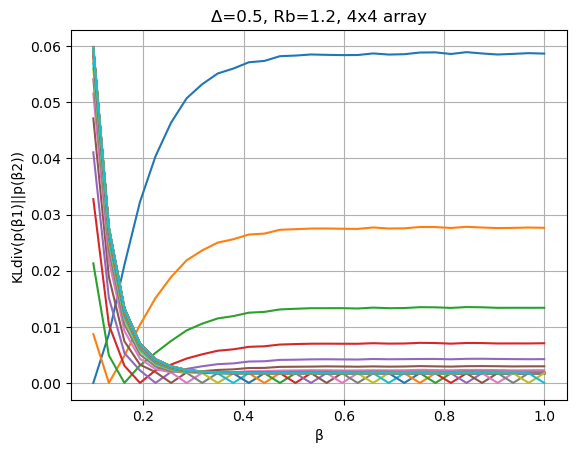

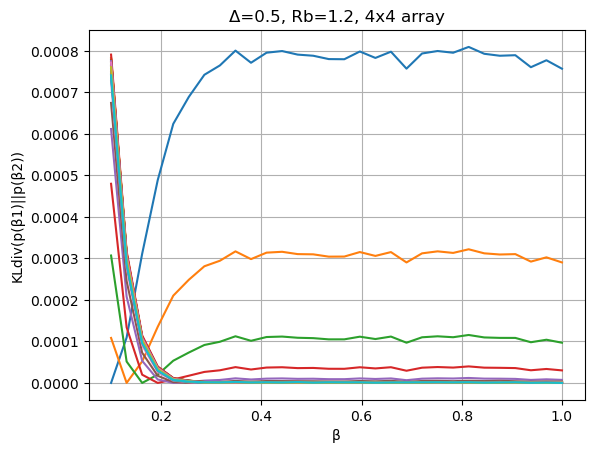

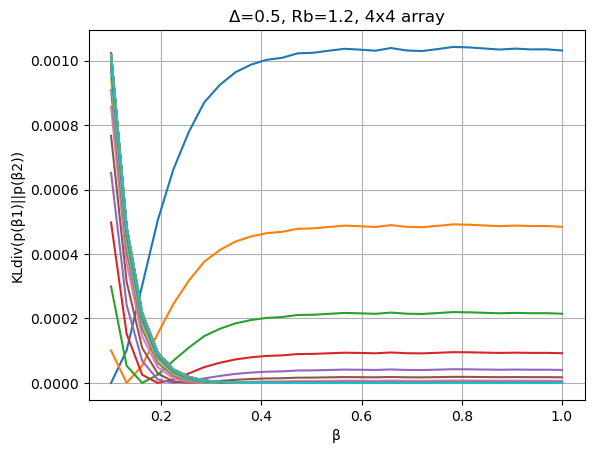

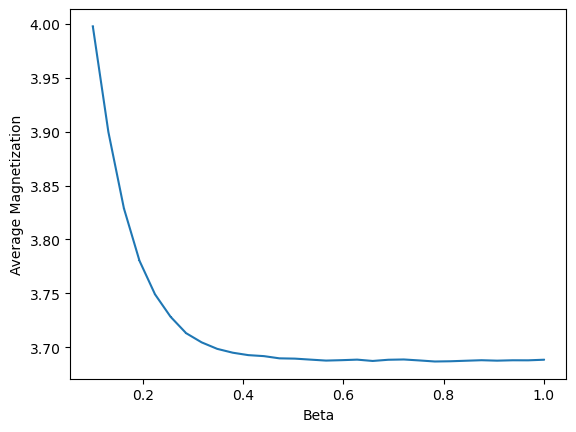

0.21878000000000003 +- 4.6773924359625845


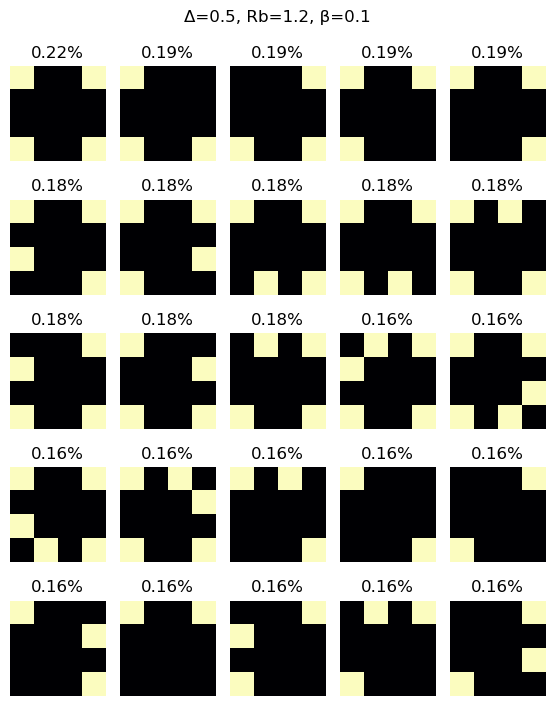

0.31824 +- 5.641276451300716


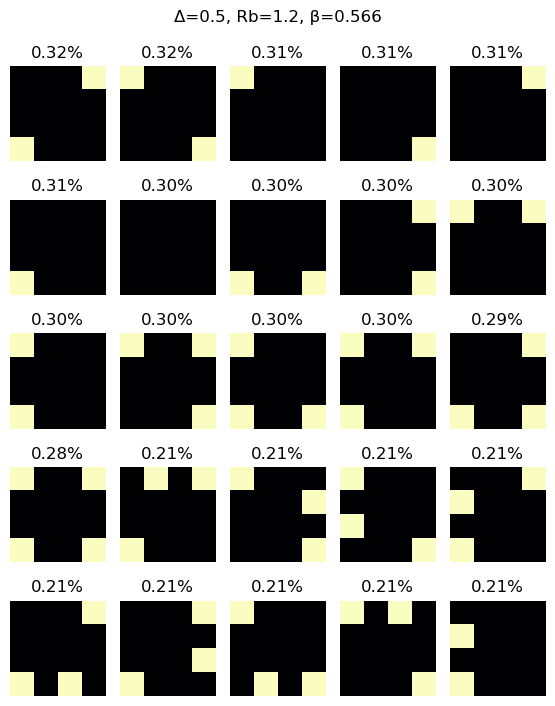

0.31757 +- 5.635334950116098


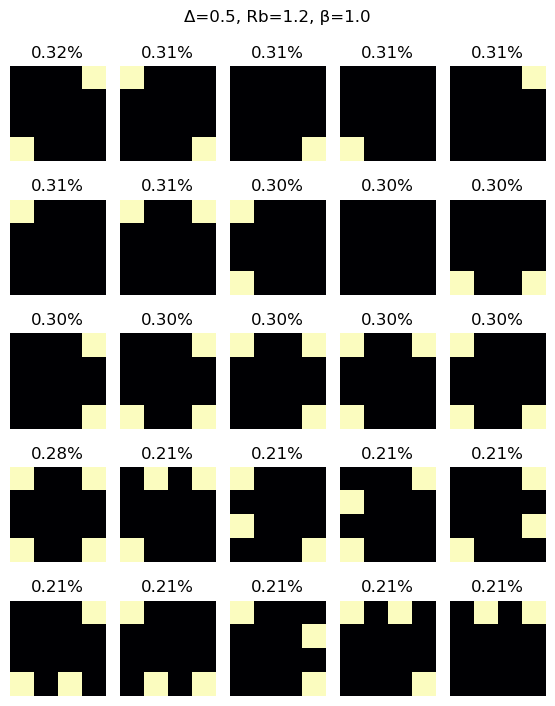

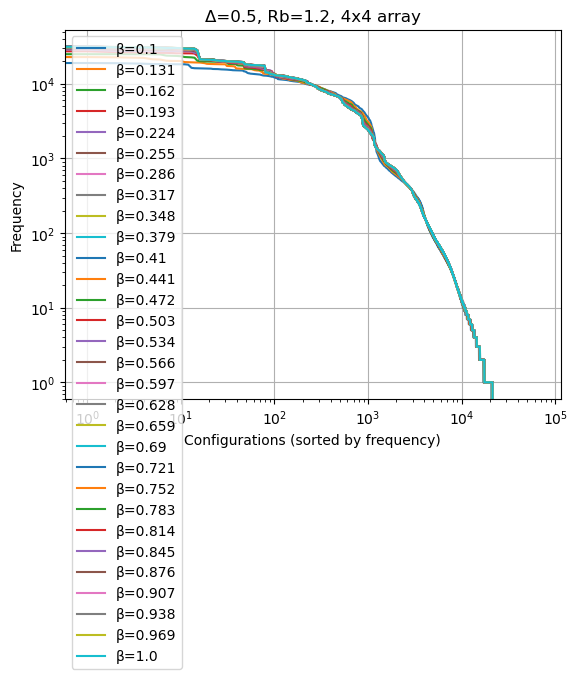

In [ ]:

%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
delta = 0.5
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=delta)

nsamples = dataset.get_nsamples()
natoms = dataset.get_natoms()
(bins, hist_list), (order_params, op_counts), (average_magnetization, std_av_magnetization), sorted_indices, beta_list = compute_histograms(dataset)
plot_KLdiv([hist/nsamples for hist in hist_list], beta_list, delta)
plot_KLdiv([op_count/nsamples for op_count in op_counts], beta_list, delta)
plot_KLdiv([np.array([1-av/natoms,av/natoms]) for av in average_magnetization], beta_list, delta)
plt.errorbar(beta_list, average_magnetization, yerr=std_av_magnetization)
plt.ylabel('Average Magnetization')
plt.xlabel('Beta')
plt.show()
for k in [0, 15, 29]:
    plot_common_configurations(hist_list[k]/nsamples, beta_list[k], sorted_indices[k], dataset.get_natoms(), delta)
plot_sorted_hist(hist_list,beta_list, sorted_indices, delta)


Observations
* For $\Delta=0.5$ (disordered state)
    * low $\beta$ values have their most frequent states being less common (2% compared to 1%), with the probabilities spread out to more states. This is expected since higher temperatures allow more states to be possible
    * Some of the most common states for all $\beta$ values are when the corners are filled, where higher temperatures want more corners to be filled (4 for low $\beta$, and 2 opposite corners for high $\beta$).
    * For low temperatures, common states are when few are filled. As the frequency drops, more and more atoms are put in. Filling up the corners in different permutations. The first state where atoms start a checkerboard pattern is when there are three atoms
    * For higher temperatures, higher number of atoms are more frequent than fewer. Small checkerboard patterns are much more frequent here.
    * The number of states that are possible are around the same for each temperature
    * The states which exist for increasing $\beta$ start being roughly the same. Small $\beta$ values have very different states than higher $\beta$ values, but $\beta$ changing from 0.5 to 1 doesn't have much of a change.
    
KL divergences
* For $p(\text{configuration})$
    * Plots don't have much noise going from one $\beta$ value to the next
    * KL divergence doesn't approach zero, except for when the datasets are identical (if this was a different seed, I would expect the KLdiv to be normal)
    * Plot looks quite like the p(1 or 0) plot except shifted up.
* For $p(\text{order})$
    * Plots have a significant amount of noise from one $\beta$ to the next
    * KL divergence does none-the-less approach 0 because of number statistics
    * In this case, the plot looks like the 0s and 1s KL divergece, but doesn't seem to always be the case
* For $p(\{0,1\})$
    * KL divergence approaches 0 because of number statistics
    * Curve is smooth
    * This means that just the amount of 0s and 1s (so long as it doesn't reach the ground state) is capable of identifying the state.

Magnetization vs temperature
* This plot shows that using the average number of excited atoms, you can get a reasonable estimate of the temperature. However, this doesn't show that the error can be characterized as a temperature, only that if there was a temperature it would be the one found here. 

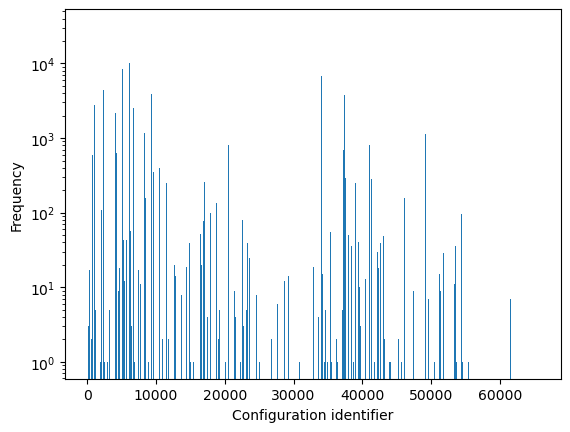

In [ ]:
plt.bar(bins[:-1], hist_values)
plt.yscale('log')
plt.xlabel('Configuration identifier')
plt.ylabel('Frequency')
plt.show()

# Probability distribribution for $\Delta=1.1$ and $R_b=1.2$

/project/6000317/jkambulo/code/qc-temp/transformer


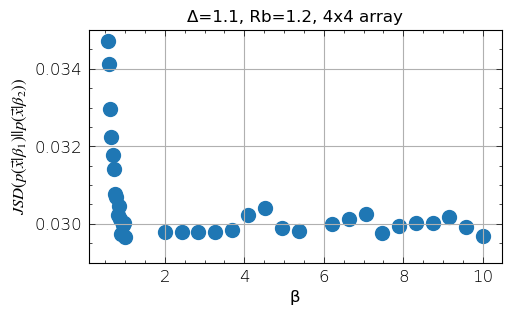

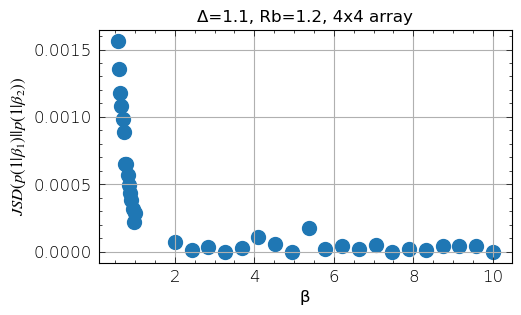

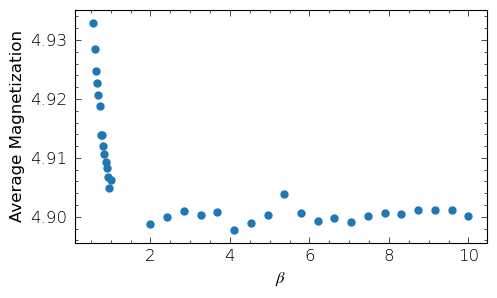

0.62244 +- 7.889486675316714


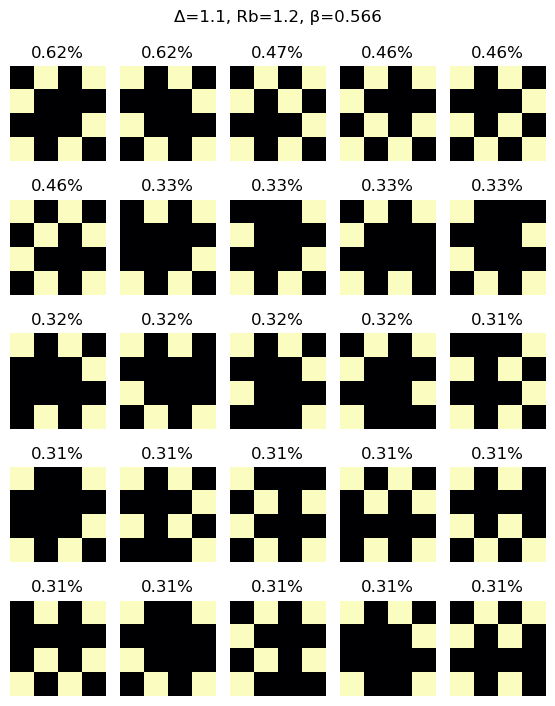

0.56102 +- 7.490126834707141


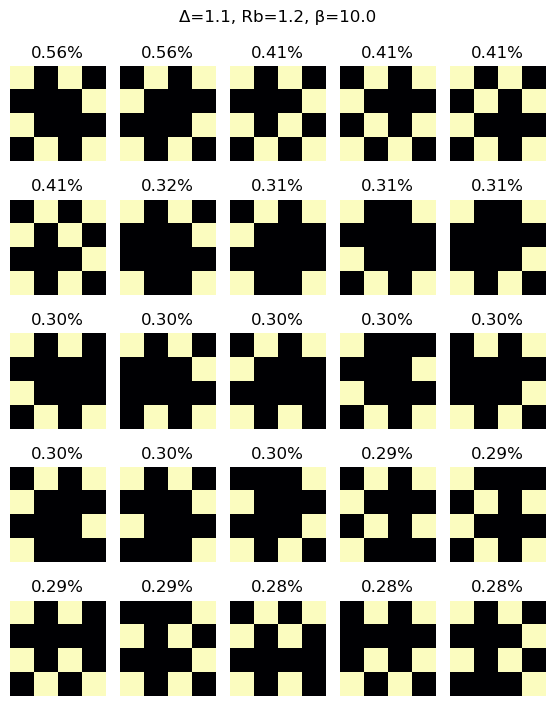

0.56061 +- 7.487389398181452


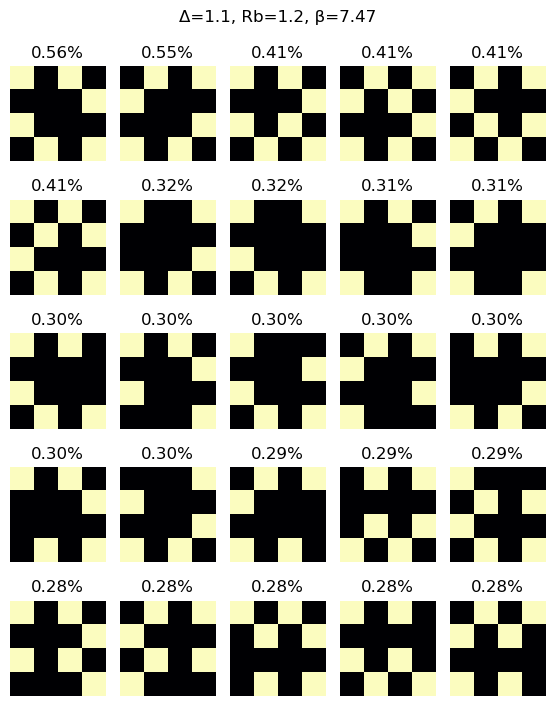

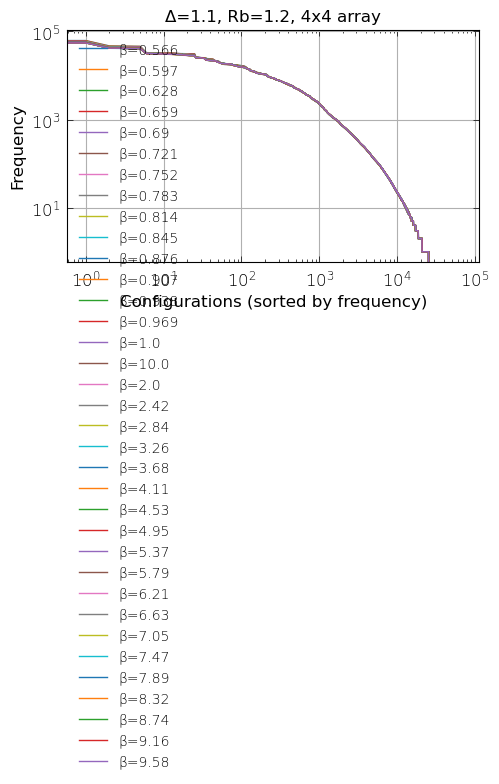

In [27]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
delta = 1.1
# dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=delta)

nsamples = dataset.get_nsamples()
natoms = dataset.get_natoms()
# (bins, hist_list), (order_params, op_counts), (average_magnetization, std_av_magnetization), sorted_indices, beta_list = compute_histograms(dataset, dataset_slice=slice(15,None))
plot_JSD(hist_list, beta_list, delta, slice(25,26),show=False)
plt.ylabel(r"$JSD(p(\vec{x}|\beta_1) || p(\vec{x}|\beta_2))$")
plt.ylim([0.029,0.035])
plt.show()
# plot_JSD(op_counts, beta_list, delta)
plot_JSD([np.array([1-av/natoms,av/natoms]) for av in average_magnetization], beta_list, delta, slice(15,16),show=False)
plt.ylabel(r"$JSD(p(1|\beta_1) || p(1|\beta_2))$")
plt.show()
plt.errorbar(beta_list, average_magnetization, yerr=std_av_magnetization, fmt='.')
plt.ylabel('Average Magnetization')
plt.xlabel(r'$\beta$')
plt.show()
for k in [0, 15, 29]:
    plot_common_configurations(hist_list[k]/nsamples, beta_list[k], sorted_indices[k], dataset.get_natoms(), delta)
plot_sorted_hist(hist_list,beta_list, sorted_indices, delta)

In [17]:
len(beta_list), len(hist_list), len(op_counts)
print(op_counts)

(array([2441755, 4076289, 2354618,  904894,  199798,   21652,     979,
            15]), array([2442897, 4074738, 2355511,  904559,  199687,   21538,    1054,
            16]), array([2442135, 4070293, 2356663,  907173,  201030,   21607,    1082,
            17]), array([2441568, 4074496, 2354759,  906115,  200766,   21262,    1016,
            18]), array([2439145, 4073756, 2355975,  907048,  201144,   21852,    1058,
            22]), array([2435790, 4067088, 2360511,  910727,  202897,   21939,    1035,
            13]), array([2436657, 4069045, 2358548,  909760,  203120,   21831,    1024,
            15]), array([2437476, 4069707, 2357655,  910624,  201899,   21548,    1076,
            15]), array([2436959, 4066047, 2360344,  910660,  203121,   21820,    1039,
            10]), array([2431992, 4068555, 2358777,  913251,  204241,   22128,    1042,
            14]), array([2438904, 4066048, 2358387,  909766,  203722,   22147,    1011,
            15]), array([2436391, 4068208, 235663

# Probability distribribution for $\Delta=2.7$ and $R_b=1.2$

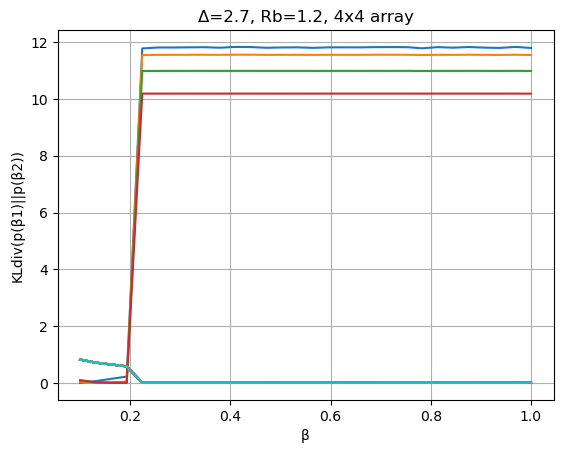

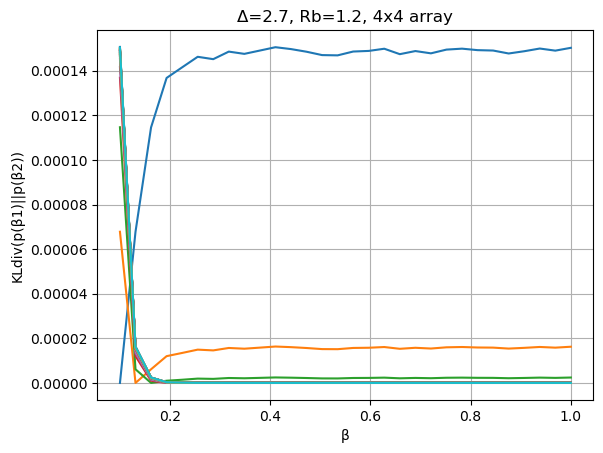

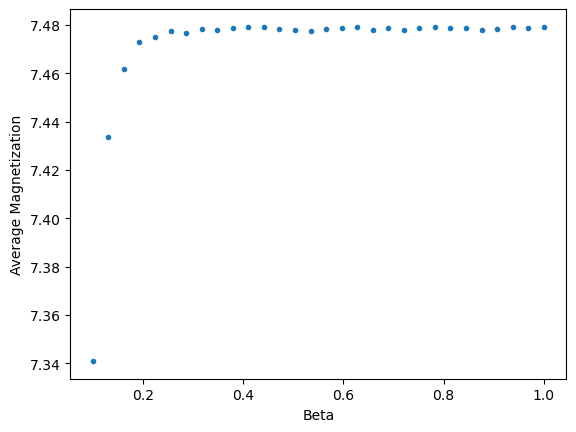

18.98909 +- 43.5764730101003


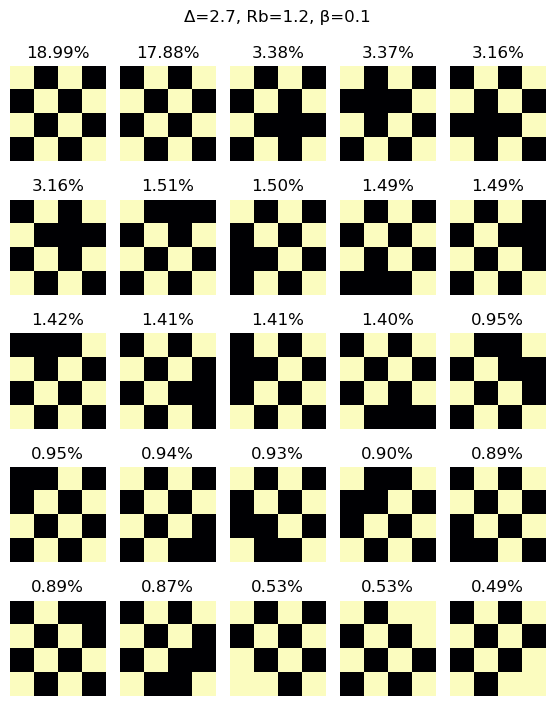

45.87302 +- 67.72962424227673


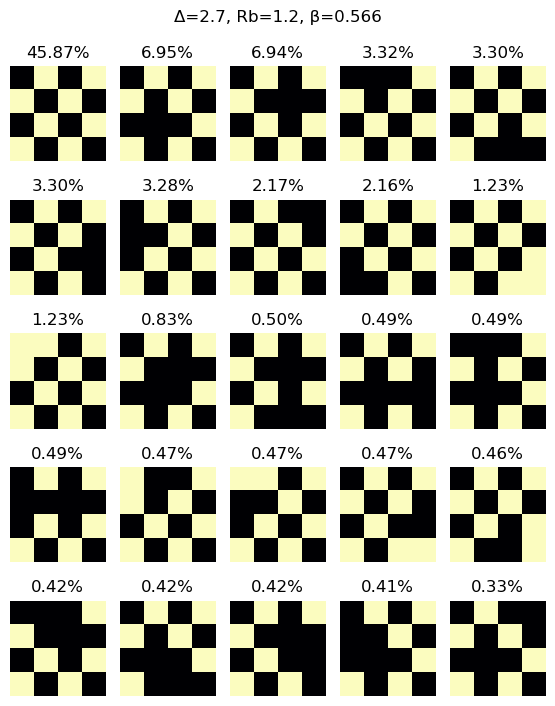

45.93559 +- 67.77579951575636


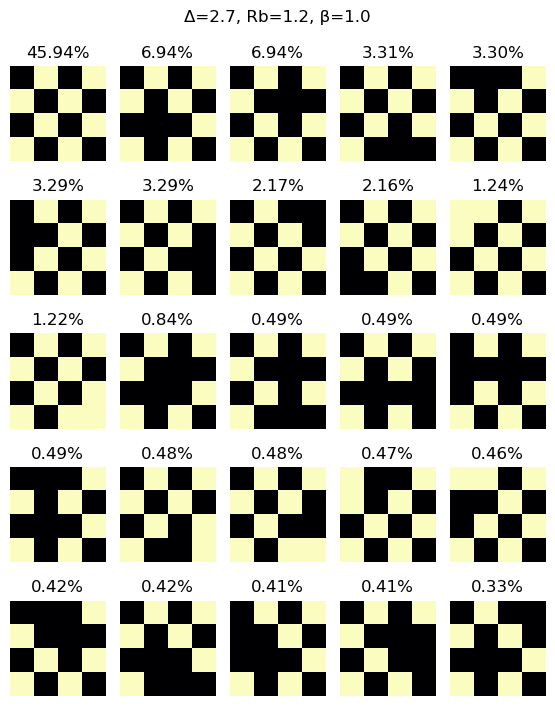

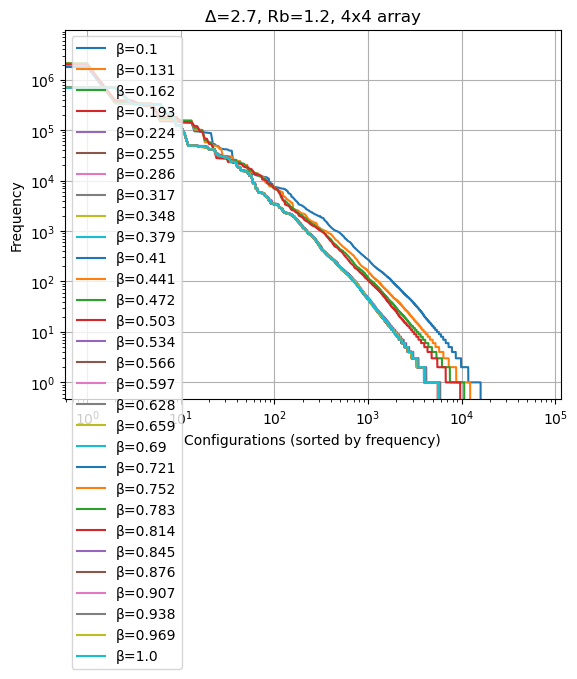

In [ ]:
# %cd /project/6000317/jkambulo/code/qc-temp/transformer
# from dataloader import QCTempDataset
# import matplotlib.pyplot as plt
# import numpy as np
# delta = 2.7
# dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=delta)

# nsamples = dataset.get_nsamples()
# natoms = dataset.get_natoms()
# (bins, hist_list), (order_params, op_counts), (average_magnetization, std_av_magnetization), sorted_indices, beta_list = compute_histograms(dataset)

plot_KLdiv([(hist+0.00001)/np.sum(hist+0.00001) for hist in hist_list], beta_list, delta)
# plot_KLdiv([op_count/nsamples for op_count in op_counts], beta_list, delta)
plot_KLdiv([np.array([1-av/natoms,av/natoms]) for av in average_magnetization], beta_list, delta)
plt.errorbar(beta_list, average_magnetization, yerr=std_av_magnetization, fmt='.')
plt.ylabel('Average Magnetization')
plt.xlabel('Beta')
plt.show()
for k in [0, 15, 29]:
    plot_common_configurations(hist_list[k]/nsamples, beta_list[k], sorted_indices[k], dataset.get_natoms(), delta)
plot_sorted_hist(hist_list,beta_list, sorted_indices, delta)




* In the checkerboard pattern, the ground state is reached at relatively high temperatures ($\beta=0.2$)
* For higher temperatures, the inverse full checkerboard pattern is equally common as the normal full checkerboard pattern. However, for lower temperatures, the inverse full checkerboard pattern becomes statistically infavorable.

If the temperature of the quantum computer doesn't depend on the Hamiltonian, then to find the temperature even when it is very low, we will want to find a state where the ground state is at a very low temperature. From these results, have a really large $\Delta$ makes the ground state have a very high temperature. Low $\Delta$ values have a somewhat high ground state temperature. The critical point seems to have the lowest ground state temperature. 

1. I want to make a plot of ground state temperature vs $\Delta/\Omega$ at $R_b=1.2$
    1. What do you consider the ground state temperature?
2. I want to have some error bars for the KL divergence to see, what the minimum number of samples are required to be confident about what the temperature is.
    

## Error of estimating Temperature

/project/6000317/jkambulo/code/qc-temp/transformer
1.2277777777777779
1.6384931255169337 1.0943067405937725


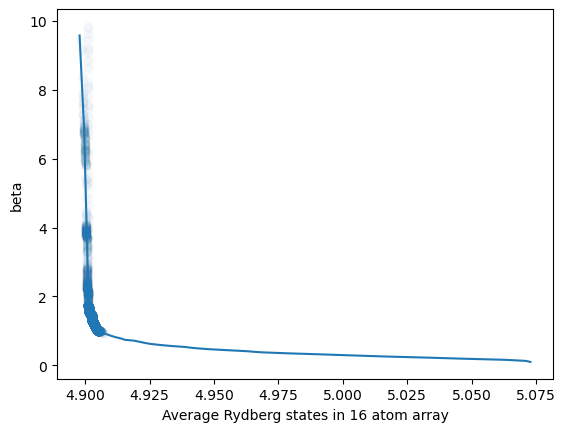

In [5]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
# from scipy.interpolate import make_interp_spline
# from dataloader import QCTempDataset
# import matplotlib.pyplot as plt
# import numpy as np
# delta = 1.1
# dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=delta)

nmeasurements = 1e6
# nsamples = dataset.get_nsamples()
# magnetization = [np.sum(data)/nsamples for data in dataset.datasets]
# f = make_interp_spline(sorted(magnetization), dataset.beta[::-1],k=1) # I'm sorting to make it monotonically increasing (just an estimate)
x=np.linspace(min(magnetization),max(magnetization),100)
plt.plot(x, f(x))
print(dataset.beta[32])
samples = np.random.normal(loc=np.sum(dataset.datasets[32])/nsamples,
                           scale=np.std(np.sum(dataset.datasets[5],axis=0))/np.sqrt(nmeasurements), 
                           size=(10000,))
plt.scatter(samples, f(samples), alpha=0.01, marker='o')
plt.ylabel('beta')
plt.xlabel("Average Rydberg states in 16 atom array")
result = f(samples)
print(np.mean(result),np.std(result))

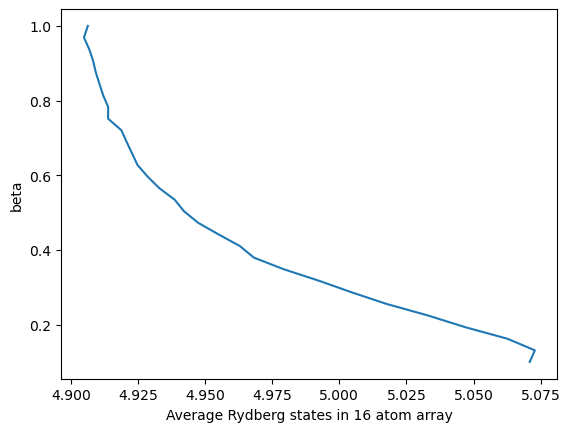

In [ ]:
# the actual plot, if I didn't sort it. 
plt.plot(magnetization, dataset.beta)
plt.ylabel('beta')
plt.xlabel("Average Rydberg states in 16 atom array")
plt.show()

The $\beta$ accuracy depends on the $\beta$ value which the quantum computer looks like. High $\beta$ values (low temperatures) will have lower accuracy.
| Measurements | Worse case accuracy | Best case accuracy |
| --- | --- | --- |
| $10^4$ | bad | 0.027 |
| $10^5$ | 0.09 | 0.0086 |
| $10^6$ | 0.030 | 0.0027 |
| $10^7$ | 0.010 | 0.0008 |

In [ ]:
from scipy.spatial.distance import jensenshannon
# (bins, hist_list), (order_params, op_counts), (average_magnetization, std_av_magnetization), sorted_indices, beta_list = compute_histograms(dataset)
# plot_KLdiv([hist/nsamples for hist in hist_list], beta_list, delta, slice(0,-1,5))

x = np.arange(2**16)
i1, i2 = -3, -5
size1 = 7
size2 = 6
p_dist = hist_list[i1]/np.sum(hist_list[i1])
p_dist2 = hist_list[i2]/np.sum(hist_list[i2])
print(beta_list[i1], beta_list[i2])
print(jensenshannon(p_dist, p_dist2))
samples = 8
jsd = np.zeros((samples))
for i in range(samples):
    p1 = np.histogram(np.random.choice(x[:-1],p=p_dist, size=(10**size1,), replace=True), bins=x, density=True)[0]
    p2 = np.histogram(np.random.choice(x[:-1],p=p_dist2, size=(10**size2,), replace=True), bins=x, density=True)[0]
    jsd[i] = jensenshannon(p1, p2)
    
print(rf"| $10^{size1}$ | $10^{size2}$ | {beta_list[i1]:.3f} | {beta_list[i2]:.3f} | ${np.mean(jsd,axis=0):.4f} \pm {np.std(jsd, axis=0):.4f}$ |" )



0.9379310344827586 0.8758620689655172
0.026401281936247186
| $10^7$ | $10^6$ | 0.938 | 0.876 | $0.0567 \pm 0.0002$ |


If we have a dataset of size $N_1$ with $\beta_1$ and we calculate the JSD with another dataset of size $N_2$ and $\beta_2$, these are the expected ranges we can expect (we would recalculate for the $\beta$ value we measure). If when numberically comparing the experimental data with simulated data for the corresponding $\beta$ and they exceed the JSD range of what would be expected when the $\beta$ values are the same, then the distribution doesn't look enough like that temperature.

| $N_1$ | $N_2$ |$\beta_1$ | $\beta_2$ | JSD |
| --- | --- | --- | --- | --- |
| $10^7$ | $10^6$ | 0.224 | 0.193 | $0.0629 \pm 0.0002$ |
| $10^7$ | $10^6$ | 0.224 | 0.224 | $0.0560 \pm 0.0003$ |
| $10^7$ | $10^6$ | 0.224 | 0.255 | $0.0621 \pm 0.0002$ |
| $10^7$ | $10^5$ | 0.224 | 0.193 | $0.1360 \pm 0.0004$ |
| $10^7$ | $10^5$ | 0.224 | 0.224 | $0.1335\pm 0.0004$ |
| $10^7$ | $10^5$ | 0.224 | 0.255 | $0.1365 \pm 0.0007$ |
| $10^7$ | $10^5$ | 0.224 | 1.000 | $0.1463 \pm 0.0005$ |
| $10^7$ | $10^5$ | 0.100 | 1.000 | $0.1777 \pm 0.0007$ |
| $10^7$ | $10^4$ | 0.224 | 0.193 | $0.2849 \pm 0.0013$ |
| $10^7$ | $10^4$ | 0.224 | 0.224 | $0.2852 \pm 0.0010$ |
| $10^7$ | $10^4$ | 0.224 | 0.255 | $0.2880 \pm 0.0010$ |
| $10^7$ | $10^4$ | 0.224 | 1.000 | $0.2912 \pm 0.0016$ |
| $10^7$ | $10^4$ | 0.100 | 1.000 | $0.3093 \pm 0.0022$ |
| $10^7$ | $10^5$ | 0.969 | 0.938 | $0.1388 \pm 0.0005$ |
| $10^7$ | $10^5$ | 0.969 | 0.969 | $0.1376 \pm 0.0005$ |
| $10^7$ | $10^5$ | 0.969 | 1.000 | $0.1384 \pm 0.0004$ |
<!-- | $10^6$ | $10^6$ | 0.224 | 0.193 | $0.0765 \pm 0.0003$ |
| $10^6$ | $10^6$ | 0.224 | 0.224 | $0.0711 \pm 0.0001$ |
| $10^6$ | $10^6$ | 0.224 | 0.255 | $0.0758 \pm 0.0001$ |
| $10^6$ | $10^6$ | 0.969 | 0.938 | $0.0764 \pm 0.0003$ |
| $10^6$ | $10^6$ | 0.969 | 0.969 | $0.0725 \pm 0.0003$ |
| $10^6$ | $10^6$ | 0.969 | 1.000 | $0.0765 \pm 0.0003$ | -->


# Measuring temperature for large $\beta$

In [ ]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
delta = 1.2
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.1, delta_per_omega=delta)

nsamples = dataset.get_nsamples()
natoms = dataset.get_natoms()
(bins, hist_list), (order_params, op_counts), (average_magnetization, std_av_magnetization), sorted_indices, beta_list = compute_histograms(dataset)

/project/6000317/jkambulo/code/qc-temp/transformer


0.9001699999999999 +- 9.487728916869411


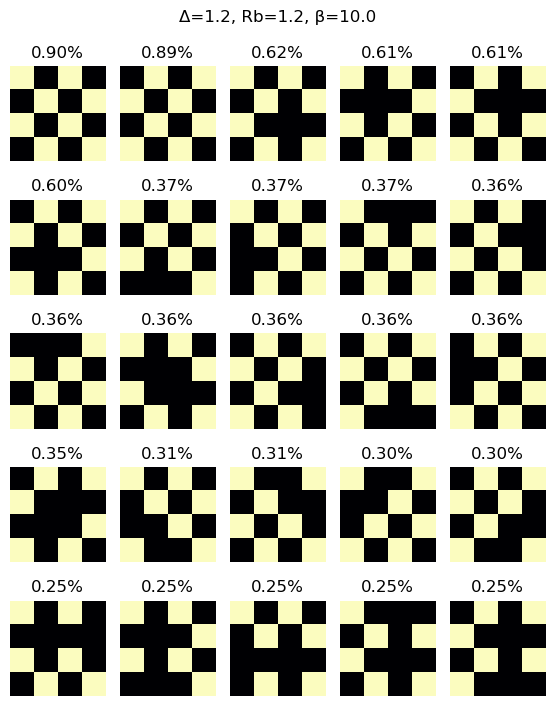

0.90493 +- 9.512780876273773


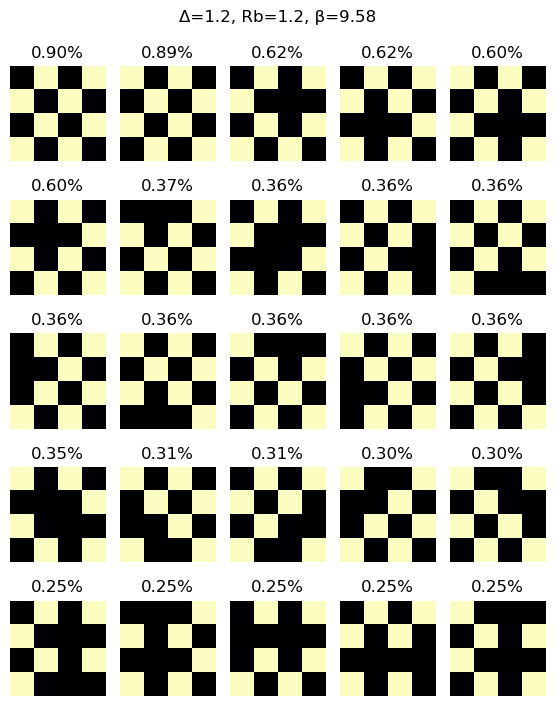

In [ ]:
plot_common_configurations(hist_list[0]/nsamples, beta_list[0], sorted_indices[0], dataset.get_natoms(), delta)
plt.show()
plot_common_configurations(hist_list[-1]/nsamples, beta_list[-1], sorted_indices[-1], dataset.get_natoms(), delta)

/tmp/ipykernel_24365/779593906.py:76: RuntimeWarning: invalid value encountered in sqrt
  print(f"{freq*100} +- {np.sqrt(freq)*100}")


-0.01408 +- nan


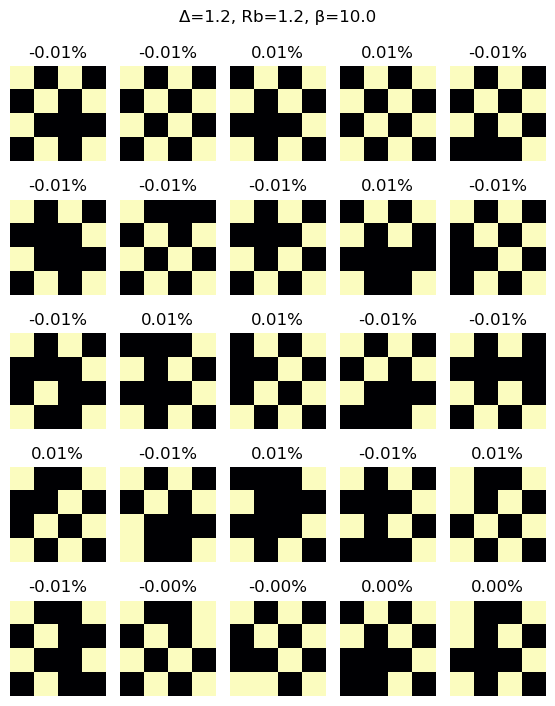

In [ ]:
vals = hist_list[4] - hist_list[0]
i = np.argsort(np.abs(vals))
plot_common_configurations(vals/nsamples, beta_list[0], i, dataset.get_natoms(), delta)
plt.show()

In [ ]:
p_dist = hist_list[0]/nsamples
x = np.arange(2**16)
size1 = 7

# iters = 20
# p = np.zeros((iters, len(x)-1))
# for i in range(iters):
#     p1 = np.histogram(np.random.choice(x[:-1],p=p_dist, size=(10**size1,), replace=True), bins=x, density=True)[0]
#     p[i] = p1

print(np.mean(p, axis=0))
print(np.std(p, axis=0)/np.mean(p, axis=0))
print(1/np.sqrt(hist_list[0]))

[1.2105e-05 4.0585e-05 2.0080e-05 ... 0.0000e+00 0.0000e+00 0.0000e+00]
[0.12057949 0.04796368 0.0609648  ...        nan        nan        nan]
[0.09166985 0.0496904  0.07071068 ...        inf        inf        inf]


/tmp/ipykernel_7869/4098821192.py:12: RuntimeWarning: invalid value encountered in divide
  print(np.std(p, axis=0)/np.mean(p, axis=0))
/tmp/ipykernel_7869/4098821192.py:13: RuntimeWarning: divide by zero encountered in divide
  print(1/np.sqrt(hist_list[0]))


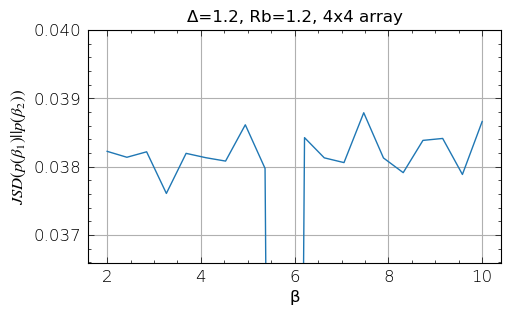

In [ ]:
plot_JSD(np.roll(hist_list,-1), np.roll(beta_list,-1), delta, show=False,beta_of_interest=slice(9,10))
plt.ylim([0.0366, 0.04])
plt.show()

In [ ]:
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), Rb_per_a=1.2, delta_per_omega=1.1)

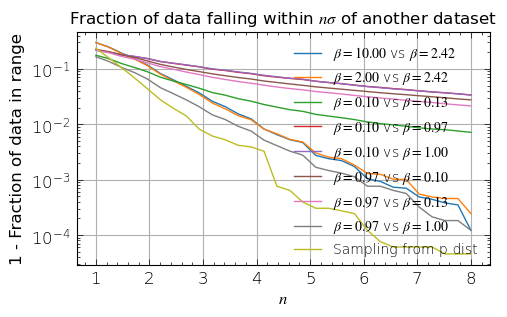

In [ ]:
from scipy.special import erf
from scipy.stats import poisson
import numpy as np

data = dataset.datasets
natoms = dataset.get_natoms()
f = lambda x: np.sum(x*(2**np.arange(natoms))[None], axis=1)
ncomb = 2**natoms

bins = np.arange(ncomb)
hist_list2 = [np.histogram(f(d[:].T), bins=bins)[0] for d in [data[0],data[1], data[-2],data[-1]]]
beta_list2 = [dataset.beta[0], dataset.beta[1],dataset.beta[-2], dataset.beta[-1]]

j = 2

mu = 300
nstd_list = np.linspace(1,8,30)
for i in range(2):
    data = []
    for nstd in nstd_list:
        # print(f'std = {nstd}')
        # print(erf(nstd/np.sqrt(2)))
        # print(poisson(mu).cdf(mu+nstd*np.sqrt(mu)) - poisson(mu).cdf(mu-nstd*np.sqrt(mu)))
        data.append(1-np.sum(((hist_list[i] - nstd*np.sqrt(hist_list[i]) <= hist_list[j]) &
                    (hist_list[j] <= hist_list[i] + nstd*np.sqrt(hist_list[i]))) |
                    (hist_list[i] == 0))/(2**16-1))
        # print(data[-1])
        # print('-'*100)
    plt.plot(nstd_list, data, label=rf'$\beta={beta_list[i]:.2f}$ vs $\beta={beta_list[j]:.2f}$')

for i in [0,2]:
    for j in [k for k in range(4) if k!=i]:
        data = []
        for nstd in nstd_list:
            data.append(1-np.sum(((hist_list2[i] - nstd*np.sqrt(hist_list2[i]) <= hist_list2[j]) &
                        (hist_list2[j] <= hist_list2[i] + nstd*np.sqrt(hist_list2[i]))) |
                        (hist_list2[i] == 0))/(2**16-1))
            
        plt.plot(nstd_list, data, label=rf'$\beta={beta_list2[i]:.2f}$ vs $\beta={beta_list2[j]:.2f}$')

# plt.plot(nstd_list[:12], 1-erf(nstd_list[:12]/np.sqrt(2)), label='Erf')
plt.plot(sample_nstd_list, sample_data, label='Sampling from p dist')
# plt.plot(nstd_list, 1-(poisson(mu).cdf(mu+nstd_list*np.sqrt(mu)) - poisson(mu).cdf(mu-nstd_list*np.sqrt(mu))), label='Poisson')
plt.xlabel(r"$n$")
plt.ylabel("1 - Fraction of data in range")
plt.title(r'Fraction of data falling within $n\sigma$ of another dataset')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

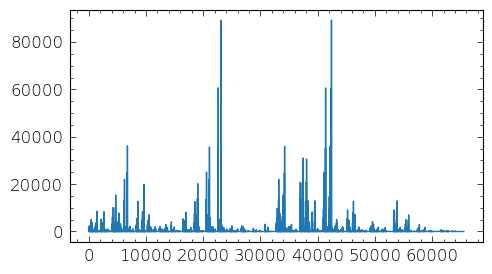

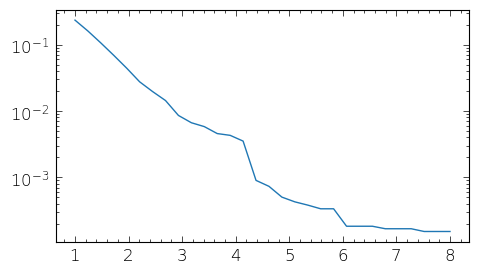

In [ ]:
x = np.arange(2**16)
dist = sum(hist_list)/len(hist_list)/nsamples

sample = np.random.choice(x[:-1], size=(nsamples,), p=dist)
dist *= nsamples
sample = np.histogram(sample, bins=x)[0]
plt.plot(x[:-1], sample)
plt.show()
sample_data = []
sample_nstd_list = np.linspace(1,8,30)
for nstd in sample_nstd_list:
    # print(f'std = {nstd}')
    # print(erf(nstd/np.sqrt(2)))
    # print(poisson(mu).cdf(mu+nstd*np.sqrt(mu)) - poisson(mu).cdf(mu-nstd*np.sqrt(mu)))
    sample_data.append(1-np.sum(((dist - nstd*np.sqrt(dist) <= sample) &
                (sample <= dist + nstd*np.sqrt(dist))) |
                (dist == 0))/(2**16-1))
# plt.plot(x,dist)
# plt.xlim([950,1050])
plt.plot(sample_nstd_list, sample_data)
plt.yscale('log')

In [120]:
import numpy as np
import tensornetwork as tn
import scipy as sp
import time
import pickle
import matplotlib.pyplot as plt

D = 16 # bond dimension of the MPS
N = 64 # number of spins in the system
J = 1.0 # interaction parameter
B = 1 # magnetic field strength
Jx = J * np.ones(N-1) # vector of interactions, one per spin-pair
Bz = B * np.ones(N) # local magnetic fields per spin
ising_mpo = tn.FiniteTFI(Jx, Bz, dtype=np.float64) # an MPO representation of the Hamiltonian for the TFI
mps = tn.FiniteMPS.random(D = [D]*(N-1), d = [2] * N, dtype=np.float64) # an initial random MPS

mps.position(0) # move the center of orthogonality to the first site of the chain

dmrg = tn.FiniteDMRG(mps, ising_mpo) #DMRG interface
dmrg.run_one_site(num_sweeps = 4, verbose=1, precision=1E-10) # run DMRG optimization

print()
sz = np.diag([-1,1]) # pauli-z operator
sx = np.array([[0,1],[1,0]]) # pauli-x operator
sz_obs = measure_local(mps,sz) # list of observables
plt.plot(sz_obs)

# Characterizing noise of Acquila data (11x11)
Anna Knorr gave me QuEra Acquila data to work with. After some analysis, I found the following about them
1. In each file (C_2D_star_XX.json/.results) contains 200 shots with a single Hamiltonian. 
2. Different files vary the Hamiltonian only by varying the atomic distance $a$. The first file has $a=4\mu m$ and the following file increments this by $0.1$, leading to the 36th file having $a=4+(36-1)*0.1=7.5 \mu m$
3. Beyond the interatomic distance, each Hamiltonian is specified by a time-dependent tuning parameter and Rabi frequency for adiabatic evolution (the phase parameter is left as zero). The Hamiltonian can be generated with the following julia code:
```julia
t = [0,2.5,2.75,3]
Δ = piecewise_linear(clocks = t, values = 8.75*[-2pi,-2pi,2pi,2pi])
Ω = piecewise_linear(clocks = t, values = 2.5*[0,2pi,2pi,0])
ϕ = piecewise_linear(clocks = [0,3], values = [0,0])
a = 4
atoms = generate_sites(SquareLattice(), 11, 11, scale = a)
h = rydberg_h(atoms; Δ=Δ, Ω=Ω,ϕ=ϕ)
```
4. In the phase space, we have: $\Delta/\Omega = 3.5$ and $R_a/a=(C/\Omega)^{1/6}/a=(2π\times 862690/(2.5\times 2\pi))^{1/6}/4= 2.093$ (rhombic/star phase) to $R_a/a=(2π\times 862690/(2.5\times 2\pi))^{1/6}/7.5= 1.11$ (checkerboard phase).

# Steps to Characterizing Noise
1. Select a Hamiltonian near the critical point. 
    * This will have the largest variety of states (more than the disordered)
    * The ground state will occur at lower temperatures.
    * The "magnetization" will change the most steadily when you increase the temperature. This allows you calculate the temperature with reasonable accuracy.
2. Measure the number of rydberg states. If $10^5$ iterations are done, you can get an estimate of the temperature to an accuracy of $\pm 0.09$ in the worst case and $\pm 0.027$ in the best case.
3. Now that we know what the temperature should be, we want to know how the error compares to normal simulations with that temperature. 

/project/6000317/jkambulo/code/qc-temp/transformer
1.0
[1.0]
0.8236 +- 0.009075241043630743


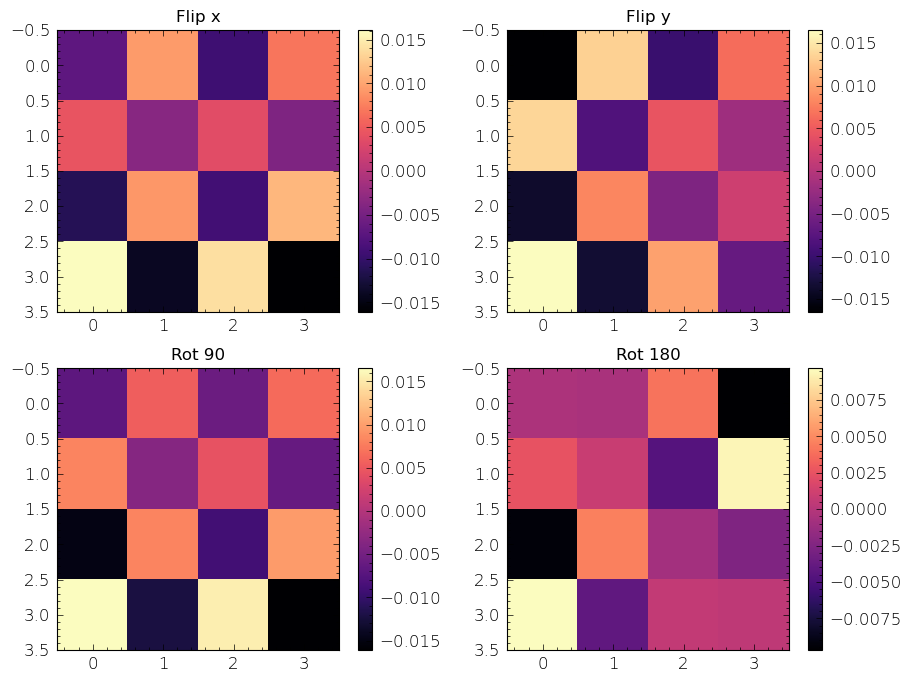

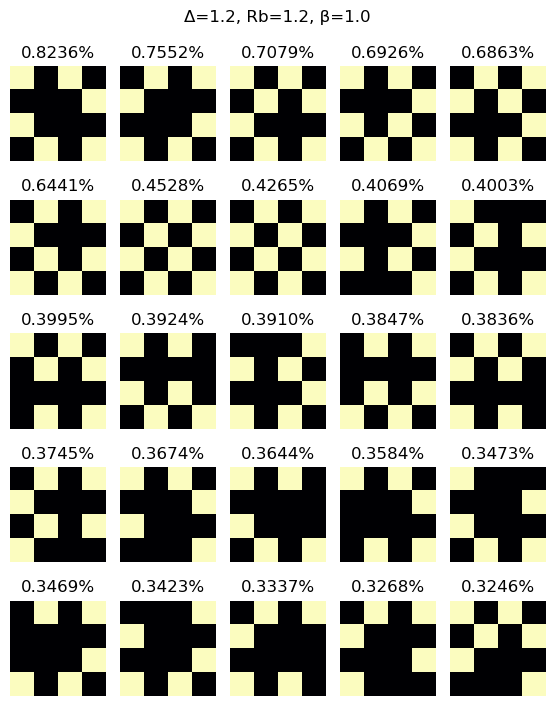

In [150]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
import numpy as np
import matplotlib.pyplot as plt
delta = 1.2
N = 4
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(N,N), lattice="CornerSquareLattice", Rb_per_a=1.1, delta_per_omega=1.2)

i = 2
operation = lambda x: x.T if i == 0 else (np.rot90(x) if i==1 else (np.rot90(x,k=3) if i==2 else np.flip(np.rot90(x),axis=1)))
dataset_i = 9
print(dataset.beta[dataset_i])
mean_value = operation(np.mean(dataset.datasets[dataset_i][N*N*i:N*N*(i+1)].reshape((N,N,-1)),axis=2))
fig, ax = plt.subplots(2,2,figsize=(10,8))
pcm = ax[0,0].imshow(mean_value - np.flip(mean_value,axis=1),cmap='magma')
ax[0,0].set_title("Flip x")
fig.colorbar(pcm, ax=ax[0,0])
pcm = ax[0,1].imshow(mean_value - np.flip(mean_value, axis=0),cmap='magma')
fig.colorbar(pcm, ax=ax[0,1])
ax[0,1].set_title("Flip y")
pcm = ax[1,0].imshow(mean_value - np.rot90(mean_value),cmap='magma')
fig.colorbar(pcm, ax=ax[1,0])
ax[1,0].set_title("Rot 90")
pcm = ax[1,1].imshow(mean_value - np.rot90(mean_value,k=2),cmap='magma')
fig.colorbar(pcm, ax=ax[1,1])
ax[1,1].set_title("Rot 180")

(bins, hist_list), _, (average_magnetization, std_av_magnetization), index_commonality, beta_list  = compute_histograms(dataset, slice(dataset_i,dataset_i+1), slice(N*N*i,N*N*(i+1)), atoms=N*N)
print(beta_list)

plot_common_configurations(hist_list[0]/np.sum(hist_list[0]), beta_list[0], index_commonality[0], N*N, 1.2, show=True)

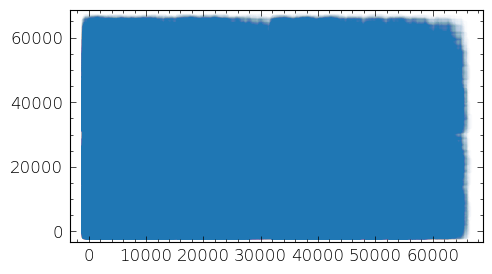

In [159]:
from scipy.stats import pearsonr
i = 0
j = 1
f = lambda x: np.sum(x*(2**np.arange(16))[None], axis=1)
plt.scatter(f(dataset.datasets[0][16*i:16*(i+1)].T),f(dataset.datasets[0][16*j:16*(j+1)].T),marker=',',alpha=0.01)

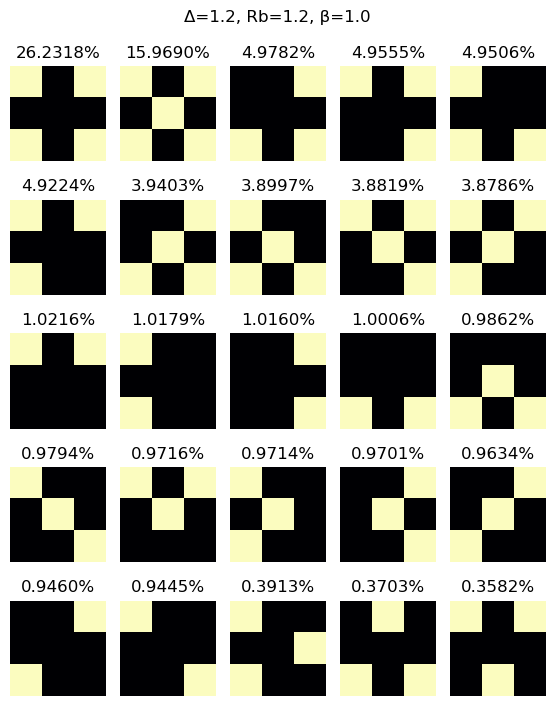
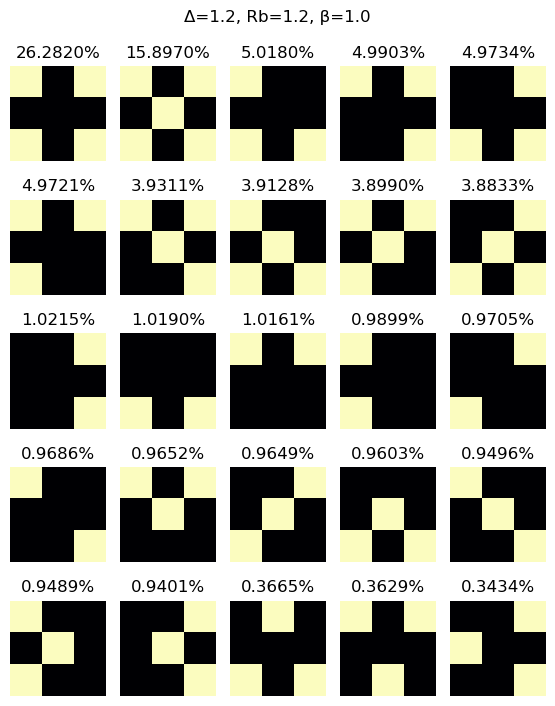
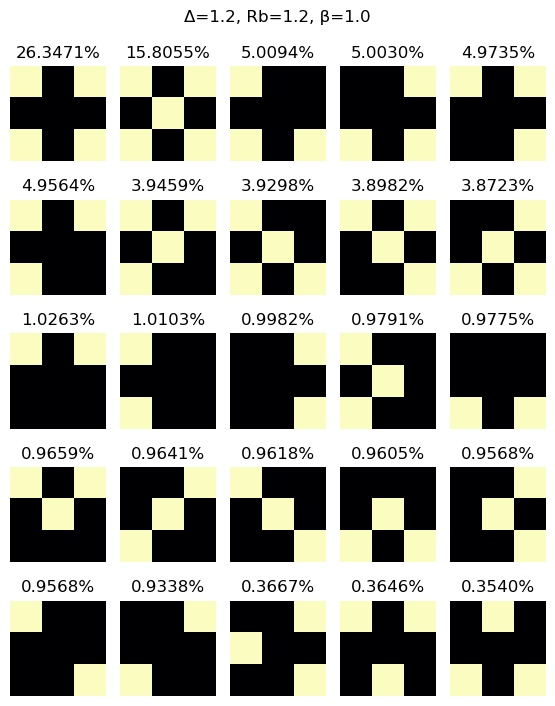
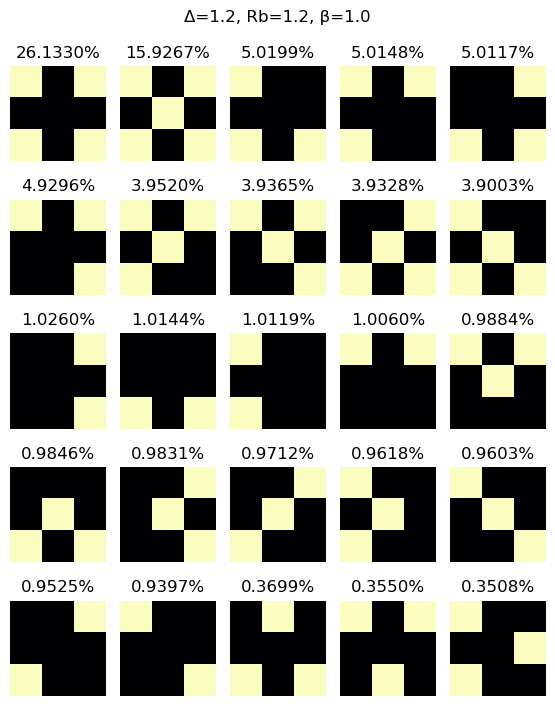

In [27]:
%cd /project/6000317/jkambulo/code/qc-temp/transformer
from dataloader import QCTempDataset
import numpy as np
import matplotlib.pyplot as plt
delta = 1.1
rb = 1.1
N = 4
dataset = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(4,4), lattice="CornerSquareLattice", Rb_per_a=rb, delta_per_omega=delta)
dataset2 = QCTempDataset("/home/jkambulo/projects/def-rgmelko/jkambulo/data/qc-temp", size=(3,3), lattice="CornerSquareLattice", Rb_per_a=rb, delta_per_omega=delta)
print(len(dataset.datasets))
print(len(dataset2.datasets))

/project/6000317/jkambulo/code/qc-temp/transformer
3
1


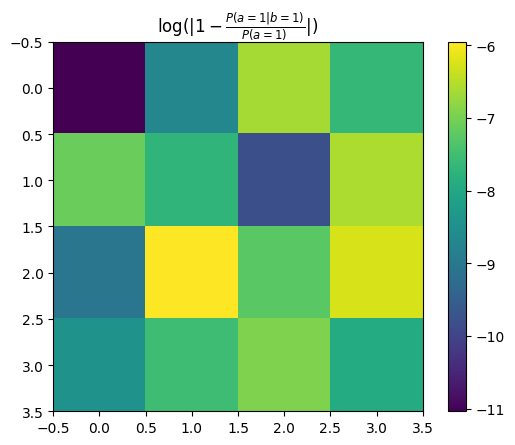

In [38]:
compare_i = 12
grid_n = 3
data_1 = dataset.datasets[0][compare_i,:]
data_2 = dataset.datasets[0][compare_i+1,:]
p = np.zeros((4,4))
for k in range(0,16):
    data_3 = dataset.datasets[0][k+16*grid_n,:]
    length = len(data_3)
    # p_00 = np.sum((data_13 == 0) & (data_29 == 0))/length
    # p_01 = np.sum((data_13 == 0) & (data_29 == 1))/length
    p11 = np.sum((data_1 == 1) & (data_3 == 1))/length
    # p111 = np.sum((data_1 == 1) & (data_2 == 1) & (data_3 == 1))/length
    # p11_ = np.sum((data_1 == 1) & (data_2 == 1))/length
    p_1 = np.sum(data_3 == 1)/length
    p1_ = np.sum(data_1 == 1)/length
    # print(p11, p1_, p_1)
    # p_1a = np.sum(data_1)/length
    p[k%4, k//4] = np.log(np.abs(1-p11/(p1_*p_1)))

plt.imshow(p)
plt.colorbar()
plt.title(r"$\log(|1-\frac{P(a=1|b=1)}{P(a=1)}|)$")
plt.show()
# print(p_11/(p_1a*p_1b))
# print(p_00/((1-p_1a)*(1-p_1b)))



In [19]:
import numpy as np
x = np.random.randint(0,2,size=(16,4))
print(x.reshape((-1,4,4,)))
# print(np.triu(x[None]*x[:,None],k=1))
c = np.arange(16)
distances = np.triu((1/((c[None]%4 - c[:,None]%4)**2+(c[None]//4 - c[:,None]//4)**2)**3),k=1)
i,j = np.triu_indices(16,k=1)
i = i[:,None]
j = j[:,None]
# np.sum(distances[np.triu(x[None,:,None]*x[:,None,None],k=1).astype(bool)])
# distances[np.array([[1],[2],[3]]),np.array([[2],[3],[4]])]

filter = (x[i] == 1) & (x[j] == 1)
print(i.shape,filter.shape)
np.sum(distances[i[:,None]*filter,j[:,None]*filter],axis=0)


[[[0 0 0 1]
  [0 1 1 0]
  [1 0 1 0]
  [1 0 0 1]]

 [[1 1 1 1]
  [1 1 1 0]
  [0 0 1 0]
  [0 0 0 0]]

 [[0 1 0 1]
  [0 0 0 0]
  [1 1 0 1]
  [0 1 0 0]]

 [[0 0 1 0]
  [0 1 1 0]
  [0 0 1 0]
  [1 0 0 1]]]
(120, 1) (120, 1, 4)


/home/jkambulo/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


array([[2.42840503, 4.70994661, 7.5032299 , 2.18002841]])

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 1,  ..., 1, 1, 1],
        [0, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


319.4179992675781